### Implementing a GPT model from Scratch To Generate Text

#### 4.1 Coding a LLM architecture

In [61]:
GPT_CONFIG_124M = {
    "vocab_size": 50257,
    "context_length": 1024,
    "emb_dim": 768,
    "n_heads": 12,
    "n_layers": 12,
    "drop_rate": 0.1,
    "qkv_bias": False
}

In [62]:
import torch
import torch.nn as nn

class DummyGPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.stf_blocks = nn.Sequential(*[
            DummyTransformerBlock(cfg) for _ in range(cfg["n_layers"])
        ])
        self.final_norm = DummyLayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        
        x = tok_embeds + pos_embeds
        
        x = self.drop_emb(x)
        x = self.stf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)
        
        return logits
    
class DummyTransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
    
    def forward(self, x):
        return x
    
class DummyLayerNorm(nn.Module):
    def __init__(self, normalized_shape, sps=1e-5):
        super().__init__()
    
    def forward(self, x):
        return x

In [63]:
import tiktoken

tokenizer = tiktoken.get_encoding("gpt2")

batch = []

text1 = "Every effort moves you"
text2 = "Every day holds a"

batch.append(torch.tensor(tokenizer.encode(text1)))
batch.append(torch.tensor(tokenizer.encode(text2)))

batch = torch.stack(batch, dim=0)

print(batch)

tensor([[6109, 3626, 6100,  345],
        [6109, 1110, 6622,  257]])


In [64]:
torch.manual_seed(123)

model = DummyGPTModel(GPT_CONFIG_124M)

logits = model(batch)

print("Output shape: ", logits.shape)

print(logits)

Output shape:  torch.Size([2, 4, 50257])
tensor([[[-1.2034,  0.3201, -0.7130,  ..., -1.5548, -0.2390, -0.4667],
         [-0.1192,  0.4539, -0.4432,  ...,  0.2392,  1.3469,  1.2430],
         [ 0.5307,  1.6720, -0.4695,  ...,  1.1966,  0.0111,  0.5835],
         [ 0.0139,  1.6754, -0.3388,  ...,  1.1586, -0.0435, -1.0400]],

        [[-1.0908,  0.1798, -0.9484,  ..., -1.6047,  0.2439, -0.4530],
         [-0.7860,  0.5581, -0.0610,  ...,  0.4835, -0.0077,  1.6621],
         [ 0.3567,  1.2698, -0.6398,  ..., -0.0162, -0.1296,  0.3717],
         [-0.2407, -0.7349, -0.5102,  ...,  2.0057, -0.3694,  0.1814]]],
       grad_fn=<UnsafeViewBackward0>)


In [65]:
model.tok_emb

Embedding(50257, 768)

In [66]:
model.pos_emb

Embedding(1024, 768)

#### 4.2 Normalizing activations with layer normalization

In [67]:
torch.manual_seed(123)
batch_example = torch.randn(2, 5)
batch_example

tensor([[-0.1115,  0.1204, -0.3696, -0.2404, -1.1969],
        [ 0.2093, -0.9724, -0.7550,  0.3239, -0.1085]])

In [68]:
torch.manual_seed(123)
layer = nn.Sequential(nn.Linear(5, 6), nn.ReLU())

out = layer(batch_example)

out

tensor([[0.9015, 0.0948, 0.6355, 0.0000, 0.4390, 0.1907],
        [0.5929, 0.7532, 0.2141, 0.2266, 0.4263, 0.0832]],
       grad_fn=<ReluBackward0>)

In [69]:
mean = out.mean(dim=-1, keepdim=True)
var = out.var(dim=-1, keepdim=True)

print(mean)
print(var)

tensor([[0.3769],
        [0.3827]], grad_fn=<MeanBackward1>)
tensor([[0.1204],
        [0.0652]], grad_fn=<VarBackward0>)


In [70]:
out_norml = (out - mean) / torch.sqrt(var)
print(out_norml)

tensor([[ 1.5115, -0.8128,  0.7451, -1.0861,  0.1788, -0.5365],
        [ 0.8233,  1.4512, -0.6605, -0.6115,  0.1708, -1.1733]],
       grad_fn=<DivBackward0>)


In [71]:
out_mean = out_norml.mean(dim=-1, keepdim=True)
out_var = out_norml.var(dim=-1, keepdim=True)

print(out_mean)
print(out_var)

tensor([[    0.0000],
        [    0.0000]], grad_fn=<MeanBackward1>)
tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


In [72]:
class LayerNorm(nn.Module):
    def __init__(self, emb_dim):
        super().__init__()
        self.eps = 1e-5
        self.scale = nn.Parameter(torch.ones(emb_dim))
        self.shift = nn.Parameter(torch.zeros(emb_dim))
        
    def forward(self, x):
        mean = x.mean(dim=-1, keepdim=True)
        var = x.var(dim=-1, keepdim=True, unbiased=False)
        normal_x = (x - mean) / torch.sqrt(var + self.eps)
        return self.scale * normal_x + self.shift

torch.manual_seed(123)  
torch.set_printoptions(sci_mode=False)
ln = LayerNorm(emb_dim=5)
out_ln = ln(batch_example)
mean = out_ln.mean(dim=-1, keepdim=True)
var = out_ln.var(dim=-1, keepdim=True, unbiased=False)

print("Mean: \n", mean)
print("Variance: \n", var)

Mean: 
 tensor([[    -0.0000],
        [     0.0000]], grad_fn=<MeanBackward1>)
Variance: 
 tensor([[1.0000],
        [1.0000]], grad_fn=<VarBackward0>)


#### 4.3 实现具有GELU 激活函数的前馈神经网络

In [73]:
class GELU(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(
            torch.sqrt(torch.tensor(2.0 / torch.pi)) * (x + 0.044715 * torch.pow(x, 3))
        ))

In [74]:
class FeedForward(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.layers = nn.Sequential(
            nn.Linear(cfg["emb_dim"], 4 * cfg["emb_dim"]),
            GELU(),
            nn.Linear(4 * cfg["emb_dim"], cfg["emb_dim"])
        )
        
    def forward(self, x):
        return self.layers(x)

In [75]:
ffn = FeedForward(GPT_CONFIG_124M)
x = torch.rand(2, 3, 768)
out = ffn(x)

print(out.shape)

torch.Size([2, 3, 768])


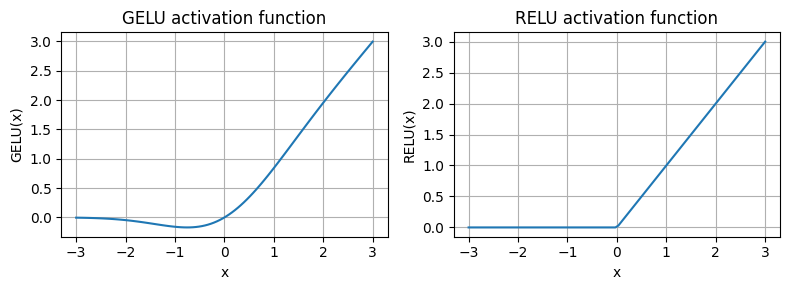

In [76]:
import matplotlib.pyplot as plt
gelu, relu = GELU(), nn.ReLU()

x = torch.linspace(-3, 3, 100)
y_gelu, y_relu = gelu(x), relu(x)
plt.figure(figsize=(8, 3))

for i, (y, label) in enumerate(zip([y_gelu, y_relu], ["GELU", "RELU"]), 1):
    plt.subplot(1, 2, i)
    plt.plot(x, y)
    plt.title(f"{label} activation function")
    plt.xlabel("x")
    plt.ylabel(f"{label}(x)")
    plt.grid(True)
    
plt.tight_layout()
plt.show()

#### 4.4 Adding shortcut connections

In [77]:
class ExampleDeepNeuralNetwork(nn.Module):
    def __init__(self, layer_size, with_shortcut):
        super().__init__()
        
        self.with_shortcut = with_shortcut
        self.layers = nn.ModuleList(
            [nn.Sequential(
                nn.Linear(layer_size[0], layer_size[1]),
                GELU()
            ),
            nn.Sequential(
                nn.Linear(layer_size[1], layer_size[2]),
                GELU()
            ),
            nn.Sequential(
                nn.Linear(layer_size[2], layer_size[3]),
                GELU()
            ),
            nn.Sequential(
                nn.Linear(layer_size[3], layer_size[4]),
                GELU()
            ),
            nn.Sequential(
                nn.Linear(layer_size[4], layer_size[5]),
                GELU()
            )]
        )
        
    def forward(self, x):
        for layer in self.layers:
            output = layer(x)
            if self.with_shortcut and x.shape == output.shape:
                x = x + output
            else:
                x = output
                
        return x
    

torch.manual_seed(123)
layer_size = [3, 3, 3, 3, 3, 1]
module_without_shortcut = ExampleDeepNeuralNetwork(layer_size, with_shortcut=False)
module_with_shortcut = ExampleDeepNeuralNetwork(layer_size, with_shortcut=True)

def print_gradients(model, x):
    output = model(x)
    target = torch.tensor([0.])
    
    loss = nn.MSELoss()
    loss = loss(output, target)
    
    loss.backward()
    
    for name, param in model.named_parameters():
        if "weight" in name:
            print(f"{name} has gradient mean of {param.grad.abs().mean().item()}")
            
input = torch.tensor([1., 0., -1.])

print_gradients(module_without_shortcut, input)
print_gradients(module_with_shortcut, input)
    

layers.0.0.weight has gradient mean of 0.00020173587836325169
layers.1.0.weight has gradient mean of 0.0001201116101583466
layers.2.0.weight has gradient mean of 0.0007152041071094573
layers.3.0.weight has gradient mean of 0.0013988735154271126
layers.4.0.weight has gradient mean of 0.005049645435065031
layers.0.0.weight has gradient mean of 0.0014432291500270367
layers.1.0.weight has gradient mean of 0.004846951924264431
layers.2.0.weight has gradient mean of 0.004138893447816372
layers.3.0.weight has gradient mean of 0.005915115587413311
layers.4.0.weight has gradient mean of 0.032659437507390976


#### 4.5 Connecting attention and linear layers in a transformer block

In [79]:
from previous_chapter import MultiHeadAttention

class TransformerBlock(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.att = MultiHeadAttention(
            d_in=cfg["emb_dim"],
            d_out=cfg["emb_dim"],
            context_length=cfg["context_length"],
            dropout=cfg["drop_rate"],
            num_heads=cfg["n_heads"],
            qkv_bias=cfg["qkv_bias"]
        )
        self.norm_1 = LayerNorm(cfg["emb_dim"])
        self.norm_2 = LayerNorm(cfg["emb_dim"])
        
        self.dropout = nn.Dropout(cfg["drop_rate"])
        
        self.ffn = FeedForward(cfg=cfg)
        
    def forward(self, x):
        shortcut = x
        
        x = self.norm_1(x)
        x = self.att(x)
        x = self.dropout(x)
        x = x + shortcut
        
        shortcut = x
        x = self.norm_2(x)
        x = self.ffn(x)
        x = self.dropout(x)
        x = x + shortcut
        
        return x

torch.manual_seed(123)

input = torch.rand(2, 4, 768)

transformer_block = TransformerBlock(GPT_CONFIG_124M)

output = transformer_block(input)

print("Input shape: ", input.shape)    
print("Output shape: ", output.shape)

Input shape:  torch.Size([2, 4, 768])
Output shape:  torch.Size([2, 4, 768])


#### 4.6 Coding the GPT model

In [81]:
class GPTModel(nn.Module):
    def __init__(self, cfg):
        super().__init__()
        self.tok_emb = nn.Embedding(cfg["vocab_size"], cfg["emb_dim"])
        self.pos_emb = nn.Embedding(cfg["context_length"], cfg["emb_dim"])
        self.drop_emb = nn.Dropout(cfg["drop_rate"])
        self.stf_blocks = nn.Sequential(*[
            TransformerBlock(cfg) for _ in range(cfg["n_layers"])
        ])
        self.final_norm = LayerNorm(cfg["emb_dim"])
        self.out_head = nn.Linear(cfg["emb_dim"], cfg["vocab_size"], bias=False)
    
    def forward(self, in_idx):
        batch_size, seq_len = in_idx.shape
        tok_embeds = self.tok_emb(in_idx)
        pos_embeds = self.pos_emb(
            torch.arange(seq_len, device=in_idx.device)
        )
        
        x = tok_embeds + pos_embeds
        x = self.drop_emb(x)
        x = self.stf_blocks(x)
        x = self.final_norm(x)
        logits = self.out_head(x)

        return logits

In [82]:
torch.manual_seed(123)

model = GPTModel(GPT_CONFIG_124M)

out = model(batch)

print(batch.shape)
print(out.shape)

torch.Size([2, 4])
torch.Size([2, 4, 50257])


In [86]:
total_params = sum(p.numel() for p in model.parameters())

print(f"Total number of parameters: {total_params:,}")

Total number of parameters: 163,009,536


In [87]:
total_params_gpt2 = (
    total_params - sum(p.numel() for p in model.out_head.parameters())
)

print(f"Total number of parameters of GPT2: {total_params_gpt2:,}")

Total number of parameters of GPT2: 124,412,160


#### 4.7 生成文本

In [91]:
def generate_text_simple(model, idx, max_new_tokens, context_size):
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
            
        logits = logits[:, -1, :]
        probas = torch.softmax(logits, dim=-1)
        idx_next = torch.argmax(probas, dim=-1, keepdim=True)
        
        idx = torch.cat((idx, idx_next), dim=1)
        
    return idx

start_context = "Hello, I am"
encoded = tokenizer.encode(start_context)

print("encoded: ", encoded)
encoded_tensor = torch.tensor(encoded).unsqueeze(0)

print(encoded_tensor)

model.eval()

out = generate_text_simple(
    model=model,
    idx=encoded_tensor,
    max_new_tokens=6,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("Output: ", out)
decode_text = tokenizer.decode(out.squeeze(0).tolist())
print(decode_text)

encoded:  [15496, 11, 314, 716]
tensor([[15496,    11,   314,   716]])
Output:  tensor([[15496,    11,   314,   716, 27018, 24086, 47843, 30961, 42348,  7267]])
Hello, I am Featureiman Byeswickattribute argue
